In [1]:
# Decomposing track into large-scale & small-scale track by
# 1. Making moving-average (MA) track which looks like it's the center line
#   (spine) of the meanders while still being relatively straight
# 2. Subtracting the angles of the MA track from the original track.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
%run ../dataPrep/trackfuns.ipynb
from scipy.signal import savgol_filter

In [3]:
# Get data
inDatFolder = r'C:\Users\stpop\Documents\MATLAB\clean_616836'
fileName = '\HRM_T1_resampled'
varNames = ['x','y','t','id','alpha','s','v','theta','alpha']
unwindDat = pd.read_csv(inDatFolder+fileName+'.txt', usecols=varNames)
ids = np.unique(unwindDat.id)

In [30]:
# Make the spine (movAv)
lowess0SMA1 = 1 # LOWESS smoothing: 0; simple moving average: 1
w = 14 # Window size to be used (must be odd for LOWESS, must be even for SMA)
wHalf = w//2

movAv = pd.DataFrame(np.zeros((1,unwindDat.shape[1])), columns=varNames)
varNames = unwindDat.columns

for id in ids:
    unwindAnt = unwindDat[unwindDat.id == id]
    currMA = pd.DataFrame(np.zeros(unwindAnt.shape), columns=varNames)
    
    if lowess0SMA1 == 0: # LOWESS averaging
        currMA.x = savgol_filter(unwindAnt.x, w, 3) # window size 51, polynomial order 3
        currMA.y = savgol_filter(unwindAnt.y, w, 3) # window size 51, polynomial order 3
        # currMA.t = somehow copying times
        
    else:                # Simple Moving Averages (not as 'good' as LOWESS)
        for ws in range(wHalf, len(unwindAnt)-wHalf): # center of current window
            currMA.iloc[ws-1,:] = np.nanmean(unwindAnt[ws-wHalf:ws+wHalf], axis=0)
        currMA = pd.DataFrame(currMA, columns=varNames)
    currMA.id = np.multiply(id, np.ones((len(currMA),1))) # ToDo: Necessary?
    movAv = pd.concat([movAv, currMA])

movAv = movAv[movAv.x != 0] # Deleting padding b/c I allocated too many zero rows above

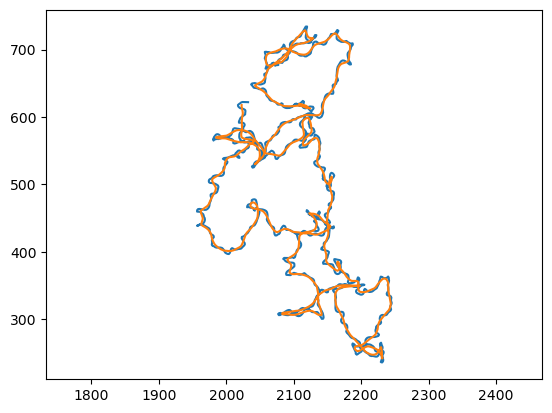

In [164]:
# Plotting track overlaid with spine
plt.rcParams.update(plt.rcParamsDefault)
id = ids[0]
currAnt = unwindDat[unwindDat.id == id]
currMovAv = movAv[movAv.id == id]
plt.plot(currAnt.x,currAnt.y)
plt.plot(currMovAv.x,currMovAv.y)
ax = plt.gca()
ax.axis('equal')
plt.show()

In [155]:
# Unwinding track on SMA (done w/ resampled ant)
antCut = pd.DataFrame(np.zeros((1,8)), columns=unwindDat.columns)
unwound = pd.DataFrame(np.zeros((1,6)), columns=['alpha','theta', 'x', 'y', 't', 'id'])
for id in ids:
    currAnt = unwindDat[unwindDat.id==id]
    currAntCut = currAnt.iloc[wHalf:-wHalf] # movAv clips beg & end of tracks
    currMovAv = movAv[movAv.id==id]

    currUnw = pd.DataFrame(np.subtract(currAntCut.alpha[1:], currMovAv.alpha[1:]), columns=['alpha'])
    currUnw['theta'] = np.cumsum(currUnw.alpha) # Initial heading theta=0 (=right (south))
    dx = np.multiply(currAntCut.s, np.cos(np.deg2rad(currUnw.theta)))
    dy = np.multiply(currAntCut.s, np.sin(np.deg2rad(currUnw.theta)))
    unwX = np.cumsum(dx)
    unwY = np.cumsum(dy)

    # Rotating the track to be horizontal
    rotAng = -np.arctan(unwY.iloc[-1]/unwX.iloc[-1])
    c, s = np.cos(rotAng), np.sin(rotAng) # Making a rotation matrix
    j = np.matrix([[c, s], [-s, c]])
    m = np.dot(j, [unwX, unwY])
    currUnw['x'] = unwX * np.cos(rotAng) - unwY * np.sin(rotAng)
    currUnw['y'] = unwX * np.sin(rotAng) + unwY * np.cos(rotAng)
    currUnw['t'] = currAnt.t[wHalf:-wHalf-1]
    currUnw['id'] = currAnt.id[wHalf:-wHalf-1]
    unwound = pd.concat([unwound, currUnw])
    antCut = pd.concat([antCut, currAntCut])
    
unwound = unwound[unwound.x != 0]
antCut = antCut[antCut.x != 0]

Text(0.5, 1.0, 'Unwound (= small scale) track')

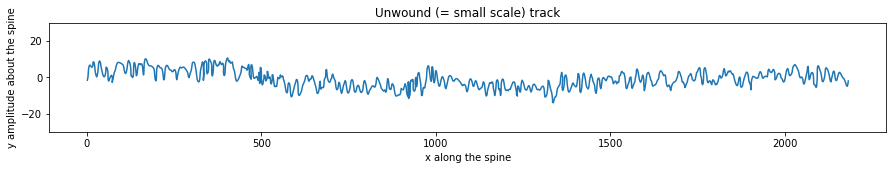

In [160]:
id = ids[0]
currUnw = unwound[unwound.id==id]
plt.rcParams['figure.figsize'] = [15, 2]
plt.plot(currUnw.x,currUnw.y)
plt.ylim(-30, 30)
plt.xlabel('x along the spine')
plt.ylabel('y amplitude about the spine')
plt.title('Unwound (= small scale) track')

In [166]:
# Save
movAv.to_csv(inDatFolder+fileName+'movAv.txt')
unwound.to_csv(inDatFolder+fileName+'unwound.txt')